In [1]:
import os
import argparse

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tqdm
import torch as th
import torchvision
from torchvision import transforms 

import cv2
import numpy as np

from scripts import *

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
img_dim = (3, 40, 80)
n_samples = 1
path = "experiments/munit_version_2_larger_image_corrected/lightning_logs/version_1/checkpoints/epoch=899.ckpt"
potsdam_dir = "../potsdam_data/potsdam_cars_all"
artificial_dir = "../potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"

transform1 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                            DynamicPad(min_img_dim=(110, 60),
                                       padding_mode="edge"),
                            transforms.RandomCrop(
                            (55, 105), padding_mode="reflect"),
                            transforms.Resize(img_dim[1:]),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])])

transform2 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                            DynamicPad(min_img_dim=(130, 70),
                                       padding_mode="constant", padding_value=125),
                            transforms.RandomRotation(
                            degrees=5, resample=PIL.Image.NEAREST, fill=125),
                            transforms.RandomCrop(
                            (60, 120), padding_mode="reflect"),
                            transforms.Resize(img_dim[1:]),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5]),
                            AddNoise(alpha=0.07)])

datasetmodule = PostdamCarsDataModule(potsdam_dir,
                                      data_dir2=artificial_dir,
                                      transform=transform1,
                                      transform2=transform2,
                                      img_size=img_dim[1:],
                                      batch_size=n_samples)
datasetmodule.setup()
dataloader = datasetmodule.train_dataloader()


In [9]:
model = MUNIT.load_from_checkpoint(path)
model.eval()
# model.cuda()

enc1 = model.generator.encoder1
dec1 = model.generator.decoder1

enc2 = model.generator.encoder2
dec2 = model.generator.decoder2

In [10]:
img_real, img_fake = next(iter(dataloader))

(-0.5, 79.5, 39.5, -0.5)

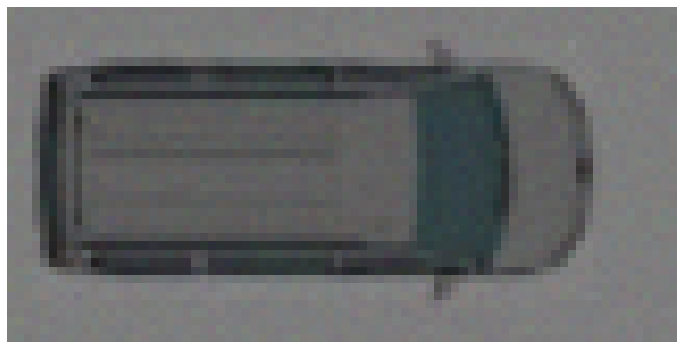

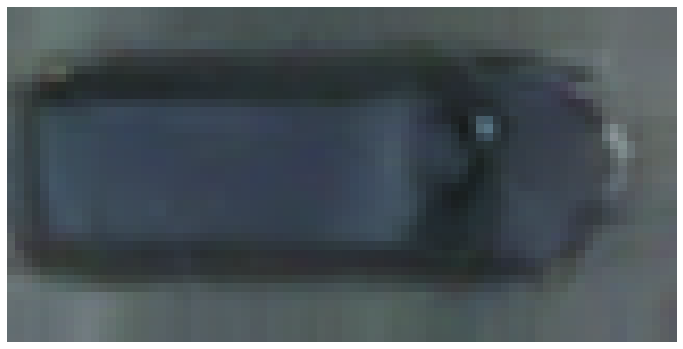

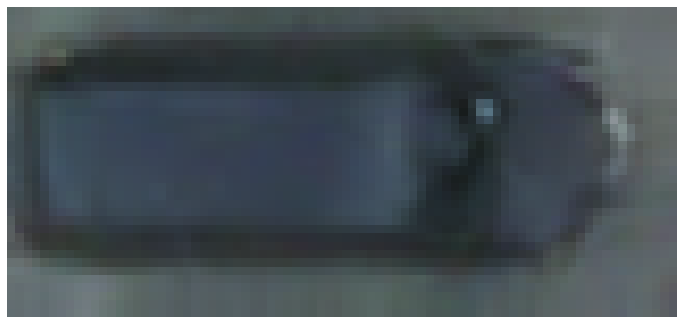

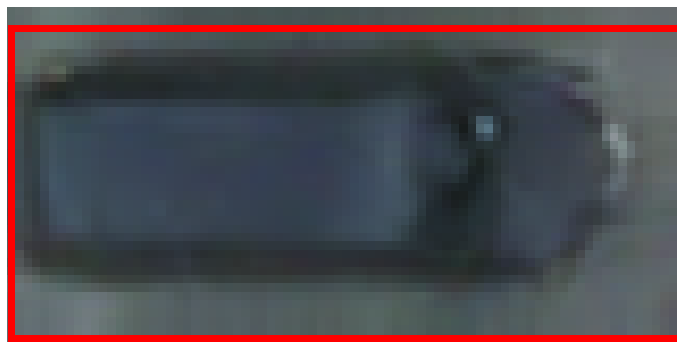

In [11]:
img_contents = img_fake.to(model.device)
random_styles = th.normal(0, 1, size=(n_samples, model.generator.style_dim), device=model.device)
# random_styles = th.zeros((n_samples, model.generator.style_dim), device=model.device)


contents, _ = enc1(img_contents)
img_realistic = dec2(contents, random_styles, False)
before_rgb = dec2(contents, random_styles, True).permute(1, 0, 2, 3).detach().cpu().clone()
grid = torchvision.utils.make_grid(before_rgb, nrow=4, pad_value=1, normalize=True)
grid = grid.permute(1, 2, 0).detach().numpy()

plt.figure(figsize=(12, 10))
#plt.subplot(3, 1, 1)
plt.imshow((th.squeeze(img_fake.detach().cpu()).permute(1, 2, 0).numpy() + 1) / 2)
plt.xticks([])
plt.yticks([])
plt.axis("off")

#plt.subplot(3, 1, 2)
plt.figure(figsize=(12, 10))
plt.imshow((th.squeeze(img_realistic.detach().cpu()).permute(1, 2, 0).numpy() + 1) / 2)
plt.xticks([])
plt.yticks([])
plt.axis("off")

m = th.squeeze(before_rgb[6]).numpy()
m /= m.max()
m[m < 0.1] = 0
m[m > 0.1] = 1
r, c = np.where(m == 1)
bufferx = 3
buffery = 3
r_min, r_max = max(0, r.min() - bufferx), min(img_dim[1], r.max() + bufferx)
c_min, c_max = max(0, c.min() - buffery), min(img_dim[2], c.max() + buffery)


m = (th.squeeze(img_realistic.detach().cpu()).permute(1, 2, 0).numpy() + 1) / 2

img = m[r_min:r_max, c_min:c_max, :]  
plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.axis("off")

rec = patches.Rectangle((c_min,r_min), (c_max - c_min), (r_max - r_min), linewidth=7,edgecolor='r',facecolor='none')
plt.figure(figsize=(12, 10))
#plt.subplot(3, 1, 3)
plt.imshow(m)
plt.gca().add_patch(rec)
plt.xticks([])
plt.yticks([])
plt.axis("off")

(-0.5, 329.5, 337.5, -0.5)

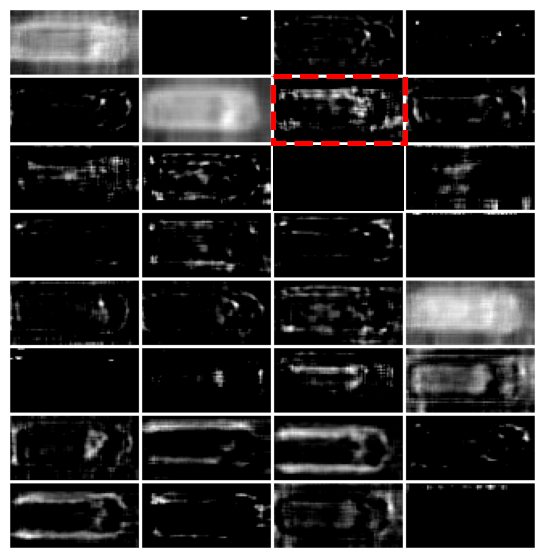

In [12]:
before_rgb = dec2(contents, random_styles, True).permute(1, 0, 2, 3).detach().cpu().clone()
for i in range(len(before_rgb)):
    before_rgb[i, :, :, :] /= th.max(before_rgb[i, :, :, :])
grid = torchvision.utils.make_grid(before_rgb, nrow=4, pad_value=1, normalize=False)
grid = grid.permute(1, 2, 0).detach().numpy()

plt.figure(figsize=(12, 10))
rec = patches.Rectangle((3*55, 42), 80 + 2, 40 + 2,linewidth=5,edgecolor='r',facecolor='none', linestyle="--",)
plt.gca().add_patch(rec)
plt.imshow(grid)
plt.xticks([])
plt.yticks([])
plt.axis("off")

In [ ]:
# do this 10000 times
import os
import argparse

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tqdm
import torch as th
import torchvision
from torchvision import transforms

import cv2
import numpy as np

from scripts import *

# save path
save_path = "experiments/munit_version_2_larger_image/version_0/10000_cars_cropped"

img_dim = (3, 40, 80)
n_samples = 1000

idx = 19
buffer = 4
path = "experiments/munit_version_2_larger_image/lightning_logs/version_0/checkpoints/epoch=424.ckpt"
potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
artificial_dir = "../potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"


os.makedirs(save_path, exist_ok=True)


transform1 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                            DynamicPad(min_img_dim=(110, 60),
                                       padding_mode="edge"),
                            transforms.RandomCrop(
                            (55, 105), padding_mode="reflect"),
                            transforms.Resize((40, 80)),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])])

transform2 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                            DynamicPad(min_img_dim=(130, 70),
                                       padding_mode="constant", padding_value=125),
                            transforms.RandomRotation(
                            degrees=5, resample=PIL.Image.NEAREST, fill=125),
                            transforms.RandomCrop(
                            (60, 120), padding_mode="reflect"),
                            transforms.Resize((40, 80)),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5]),
                            AddNoise(alpha=0.07)])

datasetmodule = PostdamCarsDataModule(potsdam_dir,
                                      data_dir2=artificial_dir,
                                      transform=transform1,
                                      transform2=transform2,
                                      img_size=img_dim[1:],
                                      batch_size=n_samples)
datasetmodule.setup()
dataloader = datasetmodule.train_dataloader()

model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

enc1 = model.generator.encoder1
dec1 = model.generator.decoder1

enc2 = model.generator.encoder2
dec2 = model.generator.decoder2

with th.no_grad():
    for i in tqdm.tqdm(range(10)):
        
        _, img_fake = next(iter(dataloader))
        img_contents = img_fake.to(model.device)
        random_styles = th.normal(0, 1, size=(n_samples, model.generator.style_dim), device=model.device)


        contents, _ = enc1(img_contents)
        imgs = dec2(contents, random_styles, False).detach().cpu().clone()
        before_rgbs = dec2(contents, random_styles, True).detach().cpu().clone()
        
        for j in range(n_samples):
        
            img_realistic = imgs[j]
            before_rgb = before_rgbs[j]

            m = th.squeeze(before_rgb[19]).numpy()
            if np.isclose(m.max(), 0):
                img_realistic = th.squeeze(img_realistic).permute(1, 2, 0).numpy()
                img = img_realistic
                img = (img + 1) / 2
                cv2.imwrite(os.path.join(save_path, f"{i*n_samples + j}.png"), cv2.cvtColor(
                    255*img, cv2.COLOR_RGB2BGR))
            else:
                m /= m.max()
                m[m < 0.1] = 0
                m[m > 0.1] = 1

                r, c = np.where(m == 1)
                r_min, r_max = max(0, r.min() - buffer), min(img_dim[1], r.max() + buffer)
                c_min, c_max = max(0, c.min() - buffer), min(img_dim[2], c.max() + buffer)

                img_realistic = th.squeeze(img_realistic).permute(1, 2, 0).numpy()
                img = img_realistic[r_min:r_max, c_min:c_max, :]  
                img = (img + 1) / 2
                cv2.imwrite(os.path.join(save_path, f"{i*n_samples + j}.png"), cv2.cvtColor(
                    255*img, cv2.COLOR_RGB2BGR))

In [ ]:
# do this 10000 times
import os
import argparse

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tqdm
import torch as th
import torchvision
from torchvision import transforms

import cv2
import numpy as np

from scripts import *

# save path
save_path = "experiments/munit_experiments/version_0/10000_cars_cropped"

img_dim = (3, 32, 64)
n_samples = 1000

idx = 11
buffer = 0
path = "experiments/munit_experiments/lightning_logs/version_0/checkpoints/epoch=499.ckpt"
potsdam_dir = "../potsdam_data/potsdam_cars_corrected"
artificial_dir = "../potsdam_data/cem-v0/v2/training_tightcanvas_graybackground"


os.makedirs(save_path, exist_ok=True)

transform1 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                            DynamicPad(min_img_dim=(110, 60),
                                       padding_mode="edge"),
                            transforms.RandomCrop(
                            (55, 105), padding_mode="reflect"),
                            transforms.Resize((32, 64)),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5])])

transform2 = transforms.Compose([transforms.ColorJitter(hue=[-0.1, 0.1]),
                            DynamicPad(min_img_dim=(130, 70),
                                       padding_mode="constant", padding_value=125),
                            transforms.RandomRotation(
                            degrees=5, resample=PIL.Image.NEAREST, fill=125),
                            transforms.RandomCrop(
                            (60, 120), padding_mode="reflect"),
                            transforms.Resize((32, 64)),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5], [0.5]),
                            AddNoise(alpha=0.07)])

datasetmodule = PostdamCarsDataModule(potsdam_dir,
                                      data_dir2=artificial_dir,
                                      transform=transform1,
                                      transform2=transform2,
                                      img_size=img_dim[1:],
                                      batch_size=n_samples)
datasetmodule.setup()
dataloader = datasetmodule.train_dataloader()

model = MUNIT.load_from_checkpoint(path)
model.eval()
model.cuda()

enc1 = model.generator.encoder1
dec1 = model.generator.decoder1

enc2 = model.generator.encoder2
dec2 = model.generator.decoder2

with th.no_grad():
    for i in tqdm.tqdm(range(10)):
        
        _, img_fake = next(iter(dataloader))
        img_contents = img_fake.to(model.device)
        random_styles = th.normal(0, 1, size=(n_samples, model.generator.style_dim), device=model.device)


        contents, _ = enc1(img_contents)
        imgs = dec2(contents, random_styles, False).detach().cpu().clone()
        before_rgbs = dec2(contents, random_styles, True).detach().cpu().clone()
        
        for j in range(n_samples):
        
            img_realistic = imgs[j]
            before_rgb = before_rgbs[j]

            m = th.squeeze(before_rgb[19]).numpy()
            if np.isclose(m.max(), 0):
                img_realistic = th.squeeze(img_realistic).permute(1, 2, 0).numpy()
                img = img_realistic
                img = (img + 1) / 2
                cv2.imwrite(os.path.join(save_path, f"{(i+1)*n_samples + j}.png"), cv2.cvtColor(
                    255*img, cv2.COLOR_RGB2BGR))
            else:
                m /= m.max()
                m[m < 0.1] = 0
                m[m > 0.1] = 1

                r, c = np.where(m == 1)
                r_min, r_max = max(0, r.min() - buffer), min(img_dim[1], r.max() + buffer)
                c_min, c_max = max(0, c.min() - buffer), min(img_dim[2], c.max() + buffer)

                img_realistic = th.squeeze(img_realistic).permute(1, 2, 0).numpy()
                img = img_realistic[r_min:r_max, c_min:c_max, :]  
                img = (img + 1) / 2
                cv2.imwrite(os.path.join(save_path, f"{(i+1)*n_samples + j}.png"), cv2.cvtColor(
                    255*img, cv2.COLOR_RGB2BGR))